## I. Initialisation

### 1) Installation des librairies prérequises

In [1]:
%%capture
# Installation des librairies
%pip install --upgrade-strategy only-if-needed tensorflow
%pip install --upgrade-strategy only-if-needed pandas
%pip install --upgrade-strategy only-if-needed numpy
%pip install --upgrade-strategy only-if-needed sklearn
%pip install --upgrade-strategy only-if-needed matplotlib
%pip install --upgrade-strategy only-if-needed seaborn
%pip install --upgrade-strategy only-if-needed opencv-python-headless==4.1.2.30
# Chargement des librairies
import pandas as pd 
import numpy as np
import tensorflow
from tensorflow import keras
import seaborn as sns
import cv2
from sklearn import preprocessing, model_selection 
from PIL import Image
import os, os.path
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

Déclaration des fonctions

In [2]:
def displayAccuracy(result_model):
    epochs = range(len(result_model.history['accuracy']))
    plt.plot(epochs, result_model.history['accuracy'], label='Training accuracy')
    plt.plot(epochs, result_model.history['val_accuracy'], label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

def displayLoss(result_model):
    epochs = range(len(result_model.history['loss']))
    plt.plot(epochs, result_model.history['loss'], label='Training loss')
    plt.plot(epochs, result_model.history['val_loss'], label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

### 2) Récupération des jeux de données (training et test)

***NOTE:*** Ne fonctionne que sur des environnements Linux (ou disposant de wget), comme Colab.

En cas d'absence de l'un ou l'autre, téléchargez manuellement les archives et placez-les à la racine du projet, et commentez les commandes `wget` et `ls` ci-dessous.

In [3]:
# Récupération des archives (depuis un drive publique)
!wget -q --show-progress --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=11TDJ-2PEihg5w4LBSUwm8_635F2kQx_E' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=11TDJ-2PEihg5w4LBSUwm8_635F2kQx_E" -O test.zip && rm -rf /tmp/cookies.txt
!wget -q --show-progress --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1xGtn32pOZ4n_vwINPTvpWNHRo3BD2yhZ' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1xGtn32pOZ4n_vwINPTvpWNHRo3BD2yhZ" -O train.zip && rm -rf /tmp/cookies.txt

# Vérification de la présence de nos données
# train.zip et test.zip
!ls -alh train.zip test.zip

# Décompression des archives
import zipfile
with zipfile.ZipFile("train.zip", 'r') as zip_ref:
  zip_ref.extractall()
with zipfile.ZipFile("test.zip", 'r') as zip_ref:
  zip_ref.extractall()

test.zip            100%[===================>]  42.45M  48.9MB/s    in 0.9s    
train.zip           100%[===================>] 199.16M  57.0MB/s    in 3.5s    
-rw-r--r-- 1 root root  43M Apr  5 16:12 test.zip
-rw-r--r-- 1 root root 200M Apr  5 16:12 train.zip


## 2. Chargement des images

Les images étant déjà classées par sous-répertoires, cela rends la tâche de chargement et classification initiale très simple par le biais de `image_dataset_from_directory`.

In [4]:
train_data = tensorflow.keras.preprocessing.image_dataset_from_directory(
  "seg_train",
  validation_split=0.2,
  label_mode="categorical",
  subset="training",
  seed=311,
  image_size=(150, 150),
  batch_size=64 # 64 images redimensionnées à 150x150px (taille constatée sur plusieurs images) par batch
)

val_data = tensorflow.keras.preprocessing.image_dataset_from_directory(
  "seg_train",
  validation_split=0.2,
  label_mode="categorical",
  subset="validation",
  seed=311,
  image_size=(150, 150),
  batch_size=64 # idem
)

test_data = tensorflow.keras.preprocessing.image_dataset_from_directory(
  "seg_test", image_size=(150, 150), batch_size=64, label_mode="categorical" # idem
)

print("Classes récupérées: {}".format(train_data.class_names))

AUTOTUNE = tensorflow.data.AUTOTUNE

train_ds_na = train_data.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = train_data.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_data.cache().prefetch(buffer_size=AUTOTUNE)

Found 14034 files belonging to 6 classes.
Using 11228 files for training.
Found 14034 files belonging to 6 classes.
Using 2806 files for validation.
Found 3000 files belonging to 6 classes.
Classes récupérées: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


Il est possible de générer un aperçu à l'aide de Matplotlib pour vérifier que les-dites classes sont correctement assignées:

Found 14034 files belonging to 6 classes.


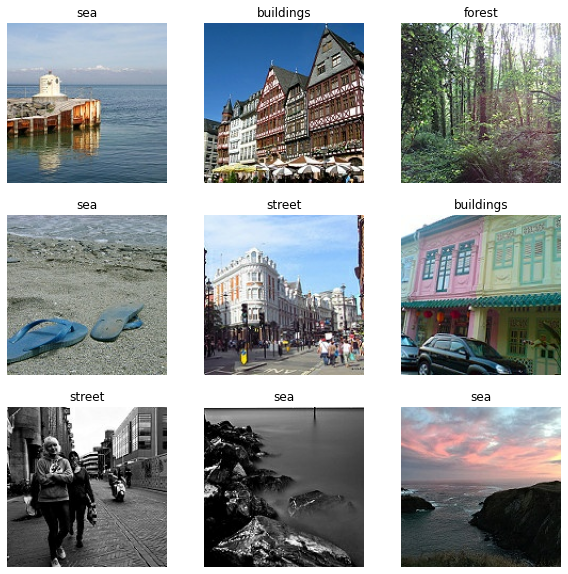

In [5]:
# Vu que le jeu que nous utiliseront par la suite est importé en mode "categorical"
# les catégories sont one-hot encodées et ne peuvent donc pas être aisément
# récupérées. plt_data n'est utilisé qu'ici à but de démonstration
plt_data = tensorflow.keras.preprocessing.image_dataset_from_directory(
  "seg_train", image_size=(150, 150), batch_size=64
)

class_names = plt_data.class_names
plt.figure(figsize=(10, 10))
for images, labels in plt_data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## 3. Preprocessing

Pour entrainer notre réseau de neurones, nous avons besoin d'utiliser une méthode d'augmentation des images à notre disposition. Pour cela, il nous est possible d'utiliser des layers dédiés au traitement de nos images, qui seront intégrées à nos modèles par la suite. En effectuant le preprocessing dans notre modèle, nous profitons des performances apportées par l'usage de la carte graphique, entre autres.

In [6]:
data_augmentation = tensorflow.keras.Sequential([
  tensorflow.keras.layers.RandomFlip("horizontal_and_vertical"),
  tensorflow.keras.layers.RandomRotation(0.2),
  tensorflow.keras.layers.RandomTranslation(0.2,0.1)
])

AUTOTUNE = tensorflow.data.AUTOTUNE

train_ds = train_ds_na.map(lambda x, y: (data_augmentation(x, training=True), y), 
  num_parallel_calls=AUTOTUNE)

Les images sont tournées, inversées et déplacées aléatoirement pour éviter que nos modèles overfit.

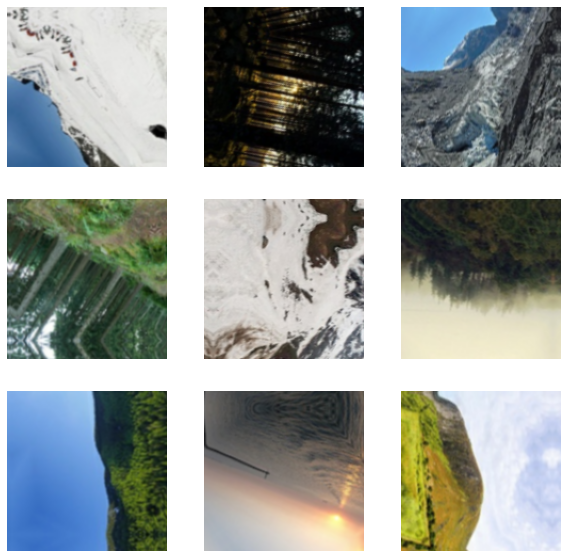

In [7]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[i].numpy().astype("uint8"))
    plt.axis("off")

## 4. Construction du modèle

### a. Premier essai

Notre premier modèle fut un test avec quelques couches de convolution et pooling.

In [8]:
model1 = tensorflow.keras.Sequential()

model1.add(tensorflow.keras.layers.Conv2D(
  32,
  kernel_size=(3, 3),
  activation='relu',
  input_shape=(150,150,3)
))
model1.add(tensorflow.keras.layers.MaxPooling2D((4, 4)))
model1.add(tensorflow.keras.layers.Conv2D(
  32,
  kernel_size=(3, 3),
  activation='relu'
))
model1.add(tensorflow.keras.layers.MaxPooling2D((4, 4)))
model1.add(tensorflow.keras.layers.Flatten())
model1.add(tensorflow.keras.layers.Dense(200, activation='relu'))
model1.add(tensorflow.keras.layers.Dense(30, activation='relu'))
model1.add(tensorflow.keras.layers.Dense(6, activation='softmax'))

model1.compile(
  optimizer='adam',
  loss='categorical_crossentropy',
  metrics=['accuracy']
)
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 37, 37, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 35, 35, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 200)              

Nous arrivons à une quantité de paramètres inférieure à 500.000.

##### Exécution

In [9]:
result_model1 = model1.fit(
  x=train_ds,
  steps_per_epoch=18,
  epochs=10,
  verbose=1,
  validation_data=val_ds,
  shuffle=True
)
print('---')
score_model1 = model1.evaluate(test_ds)

Epoch 1/10
18/18 [==============================] - 24s 801ms/step - loss: 20.9380 - accuracy: 0.1701 - val_loss: 4.1586 - val_accuracy: 0.1965
Epoch 2/10
18/18 [==============================] - 7s 424ms/step - loss: 2.2628 - accuracy: 0.2396 - val_loss: 1.9280 - val_accuracy: 0.2522
Epoch 3/10
18/18 [==============================] - 7s 423ms/step - loss: 1.7918 - accuracy: 0.2634 - val_loss: 1.8149 - val_accuracy: 0.2565
Epoch 4/10
18/18 [==============================] - 7s 417ms/step - loss: 1.6681 - accuracy: 0.3273 - val_loss: 1.5934 - val_accuracy: 0.3575
Epoch 5/10
18/18 [==============================] - 7s 419ms/step - loss: 1.5447 - accuracy: 0.3620 - val_loss: 1.5508 - val_accuracy: 0.3683
Epoch 6/10
18/18 [==============================] - 7s 415ms/step - loss: 1.4708 - accuracy: 0.3741 - val_loss: 1.4986 - val_accuracy: 0.3652
Epoch 7/10
18/18 [==============================] - 7s 423ms/step - loss: 1.4680 - accuracy: 0.3811 - val_loss: 1.6564 - val_accuracy: 0.3710
Epoc

##### Résultats

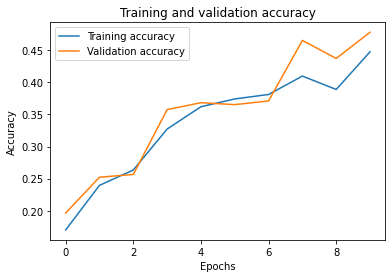

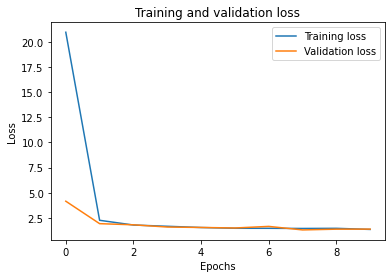

In [10]:
displayAccuracy(result_model1)
displayLoss(result_model1)

La perte par validation est faible, ce qui indique que notre augmentation d'image fonctionne bien, cependant la précision est relativement faible.

Nous avons essayé d'exécuter le modèle sur plus d'epochs, mais sans succès: le fit s'arrête à 10 à chaques fois.

### b. Deuxième essai

Notre second modèle effectue cette fois-ci des convolutions sur des batchs de 64, et comporte quelques couches en plus, y compris dropout.

In [11]:
model2 = tensorflow.keras.Sequential()

model2.add(tensorflow.keras.layers.Conv2D(
  64,
  kernel_size=(3, 3),
  activation='relu',
  input_shape=(150,150,3)
))
model2.add(tensorflow.keras.layers.MaxPooling2D((4, 4)))
model2.add(tensorflow.keras.layers.Conv2D(
  64,
  kernel_size=(3, 3),
  activation='relu'
))
model2.add(tensorflow.keras.layers.MaxPooling2D((4, 4)))
model2.add(tensorflow.keras.layers.Dropout(0.3))
model2.add(tensorflow.keras.layers.Flatten())
model2.add(tensorflow.keras.layers.Dense(50, activation='relu'))
model2.add(tensorflow.keras.layers.Dense(180, activation='relu'))
model2.add(tensorflow.keras.layers.Dense(6, activation='softmax'))

model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 37, 37, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 35, 35, 64)        36928     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 8, 8, 64)          0         
                                                                 
 flatten_1 (Flatten)         (None, 4096)             

##### Exécution

In [12]:
result_model2 = model2.fit(
  x=train_ds,
  steps_per_epoch=18,
  epochs=10,
  verbose=1,
  validation_data=val_ds,
  shuffle=True
)
print('---')
score_model2 = model2.evaluate(test_ds)

Epoch 1/10
18/18 [==============================] - 12s 574ms/step - loss: 11.1008 - accuracy: 0.1658 - val_loss: 1.8121 - val_accuracy: 0.1850
Epoch 2/10
18/18 [==============================] - 9s 551ms/step - loss: 1.8050 - accuracy: 0.1623 - val_loss: 1.7852 - val_accuracy: 0.2034
Epoch 3/10
18/18 [==============================] - 9s 553ms/step - loss: 1.7585 - accuracy: 0.2335 - val_loss: 1.7525 - val_accuracy: 0.2208
Epoch 4/10
18/18 [==============================] - 9s 554ms/step - loss: 1.6970 - accuracy: 0.2536 - val_loss: 1.6626 - val_accuracy: 0.3031
Epoch 5/10
18/18 [==============================] - 9s 549ms/step - loss: 1.6480 - accuracy: 0.2839 - val_loss: 1.5304 - val_accuracy: 0.3627
Epoch 6/10
18/18 [==============================] - 14s 836ms/step - loss: 1.5290 - accuracy: 0.3689 - val_loss: 1.5176 - val_accuracy: 0.3592
Epoch 7/10
18/18 [==============================] - 10s 556ms/step - loss: 1.6161 - accuracy: 0.3047 - val_loss: 1.5230 - val_accuracy: 0.3730
Ep

##### Résultat

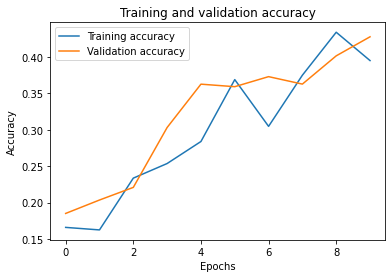

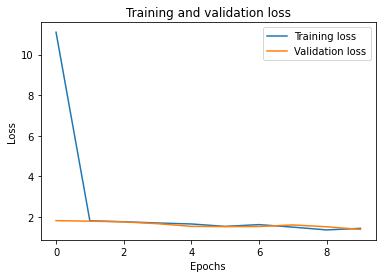

In [13]:
displayAccuracy(result_model2)
displayLoss(result_model2)

#### c. Troisième essai

In [14]:
model3 = tensorflow.keras.Sequential()


model3.add(tensorflow.keras.layers.Conv2D(
  32,
  kernel_size=(3, 3),
  activation='relu',
  input_shape=(150,150,3)
))
model3.add(tensorflow.keras.layers.BatchNormalization())
model3.add(tensorflow.keras.layers.MaxPooling2D((4, 4)))
model3.add(tensorflow.keras.layers.Dense(120, activation='relu'))
model3.add(tensorflow.keras.layers.Dropout(0.15))
model3.add(tensorflow.keras.layers.Flatten())
model3.add(tensorflow.keras.layers.Dense(6, activation='softmax'))

model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 148, 148, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 37, 37, 32)       0         
 2D)                                                             
                                                                 
 dense_6 (Dense)             (None, 37, 37, 120)       3960      
                                                                 
 dropout_1 (Dropout)         (None, 37, 37, 120)       0         
                                                                 
 flatten_2 (Flatten)         (None, 164280)           

##### Exécution

In [15]:
result_model3 = model3.fit(
  x=train_ds,
  steps_per_epoch=18,
  epochs=10,
  verbose=1,
  validation_data=val_ds,
  shuffle=True
)
print('---')
score_model3 = model3.evaluate(test_ds)

Epoch 1/10
18/18 [==============================] - 9s 466ms/step - loss: 22.1656 - accuracy: 0.2778 - val_loss: 38.2086 - val_accuracy: 0.2591
Epoch 2/10
18/18 [==============================] - 7s 437ms/step - loss: 6.1040 - accuracy: 0.4271 - val_loss: 11.7292 - val_accuracy: 0.3213
Epoch 3/10
18/18 [==============================] - 8s 452ms/step - loss: 3.3263 - accuracy: 0.4644 - val_loss: 5.5220 - val_accuracy: 0.4678
Epoch 4/10
18/18 [==============================] - 8s 443ms/step - loss: 2.6824 - accuracy: 0.4601 - val_loss: 4.5380 - val_accuracy: 0.4578
Epoch 5/10
18/18 [==============================] - 8s 440ms/step - loss: 2.3108 - accuracy: 0.4705 - val_loss: 5.9164 - val_accuracy: 0.3879
Epoch 6/10
18/18 [==============================] - 8s 438ms/step - loss: 2.2687 - accuracy: 0.4878 - val_loss: 4.3160 - val_accuracy: 0.4142
Epoch 7/10
18/18 [==============================] - 8s 445ms/step - loss: 2.0877 - accuracy: 0.4974 - val_loss: 4.4425 - val_accuracy: 0.3669
Epo

##### Résultat

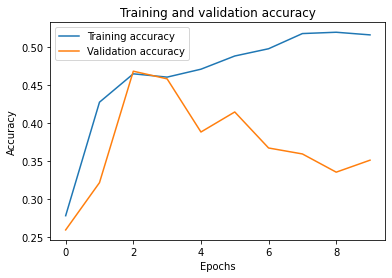

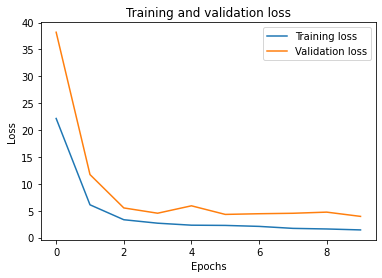

In [16]:
displayAccuracy(result_model3)
displayLoss(result_model3)

### 5. Usage du modèle

#### a. Sauvegarde

La sauvegarde du modèle est très simple: nous n'avons qu'à le sauvegarder au format h5 pour pouvoir le réutiliser par la suite. Les "weights" peuvent également être intéressant pour le futur, et peuvent être sauvegardés au format h5.

In [17]:
model3.save('model3.h5')
model3.save_weights('model3-weights.h5')
# Pour charger le modèle:
# model = terraform.keras.models.load_model('model3.h5')

#### b. Prédictions

Le but d'entrainer un modèle de reconnaissance d'images est de l'utiliser. Pour ce faire, nous utilisons une fonction qui met en conformité les images de notre répertoire dataset, et les envoyons dans nos différents modèles.

In [18]:
def get_inputs(src=[]):
    pre_x = []
    for s in src:
        input = cv2.imread(s)
        input = cv2.resize(input, (150, 150))
        input = cv2.cvtColor(input, cv2.COLOR_BGR2RGB)
        pre_x.append(input)
    pre_x = np.array(pre_x) / 255.0
    return pre_x

Nous avons préparé notre propre jeu d'images, disponible ici.
Il peut être directement préparé par le biais de la cellule suivante (*uniquement Colab/Linux*):

In [19]:
# Récupération des archives (depuis un drive publique)
!wget -q --show-progress --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1CuQtAeUYPVrPBqsRM82BMI-A9L9rKJGe' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1CuQtAeUYPVrPBqsRM82BMI-A9L9rKJGe" -O predict.zip && rm -rf /tmp/cookies.txt

with zipfile.ZipFile("predict.zip", 'r') as zip_ref:
  zip_ref.extractall()

predict.zip         100%[===================>] 942.55K  --.-KB/s    in 0.008s  


Les modèles peuvent ensuite être testés:

In [20]:
predict_dir = 'predict'
test = os.listdir(predict_dir)
images = []

for testpath in test:
    for fn in os.listdir(os.path.join(predict_dir, testpath)):
        if fn.endswith('jpg'):
            fd = os.path.join(predict_dir, testpath, fn)
            print(fd)
            images.append(fd)

pre_x = get_inputs(images)

print('Model 1 Prediction :', (model1.predict(pre_x)),
      'Model 2 Prediction :', (model2.predict(pre_x)),
      'Model 3 Prediction :', (model3.predict(pre_x)) , sep = "\n")

predict/images/Forests.jpg
predict/images/Street-art-photographie-linda-xu-7.jpg
predict/images/istockphoto-1327243304-170667a.jpg
predict/images/photo-1562797807-aa9baed9a414.jpg
predict/images/test.jpg
predict/images/21684708lpw-21684944-article-jpg_7935886_1250x625.jpg
Model 1 Prediction :
[[0.15843406 0.17644988 0.16725816 0.16707563 0.16397347 0.16680884]
 [0.16287939 0.16616084 0.16449897 0.17171963 0.17023708 0.16450411]
 [0.15976173 0.16351736 0.16736639 0.17587617 0.17217647 0.16130188]
 [0.16072181 0.16294433 0.1659462  0.17600377 0.17213343 0.16225047]
 [0.1608275  0.16532536 0.16589037 0.17368892 0.16976513 0.16450271]
 [0.1574408  0.16182025 0.16841084 0.17920204 0.17418897 0.15893705]]
Model 2 Prediction :
[[0.1769125  0.1456512  0.15672746 0.17092434 0.16278711 0.18699737]
 [0.1706413  0.13781412 0.16417012 0.1742854  0.17039679 0.18269233]
 [0.17015153 0.13679764 0.16542354 0.17530546 0.17063855 0.18168327]
 [0.17069778 0.13697095 0.16527504 0.17436667 0.17020218 0.1824

### 6. ResNet modèle

Pour terminer ce projet, nous avons créé un modèle ResNet permettant d'analyser les images.

In [21]:
base_model = tensorflow.keras.applications.resnet50.ResNet50(weights= None, include_top=False, input_shape= (150,150,3))
x = base_model.output
x = tensorflow.keras.layers.GlobalAveragePooling2D()(x)
x = tensorflow.keras.layers.Dropout(0.7)(x)
predictions = tensorflow.keras.layers.Dense(6, activation= 'softmax')(x)
resnet_model = tensorflow.keras.models.Model(inputs = base_model.input, outputs = predictions)
resnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
resnet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 156, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 75, 75, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 75, 75, 64)   256         ['conv1_conv[0][0]']         

#### Exécution

Au vu du très grand nombre de paramètres et du nombre de steps nécessaire à son bon fonctionnement, ce modèle prends beaucoup de temps à `fit`.

In [22]:
result_resnet_model = resnet_model.fit(
  x=train_ds,
  epochs=10,
  validation_data=val_ds
)
print('---')
score_resnet_model = resnet_model.evaluate(test_ds)

Epoch 1/10
176/176 [==============================] - 184s 988ms/step - loss: 1.9456 - accuracy: 0.4177 - val_loss: 1.7372 - val_accuracy: 0.3101
Epoch 2/10
176/176 [==============================] - 169s 961ms/step - loss: 1.4426 - accuracy: 0.4806 - val_loss: 14.2204 - val_accuracy: 0.2028
Epoch 3/10
176/176 [==============================] - 170s 964ms/step - loss: 1.3291 - accuracy: 0.5105 - val_loss: 1.8437 - val_accuracy: 0.4490
Epoch 4/10
176/176 [==============================] - 169s 960ms/step - loss: 1.2160 - accuracy: 0.5465 - val_loss: 3.2965 - val_accuracy: 0.1929
Epoch 5/10
176/176 [==============================] - 170s 963ms/step - loss: 1.1903 - accuracy: 0.5588 - val_loss: 7.5619 - val_accuracy: 0.1510
Epoch 6/10
176/176 [==============================] - 170s 962ms/step - loss: 1.3074 - accuracy: 0.5120 - val_loss: 2.2665 - val_accuracy: 0.4011
Epoch 7/10
176/176 [==============================] - 170s 965ms/step - loss: 1.1655 - accuracy: 0.5579 - val_loss: 3.2986 

#### Résultat

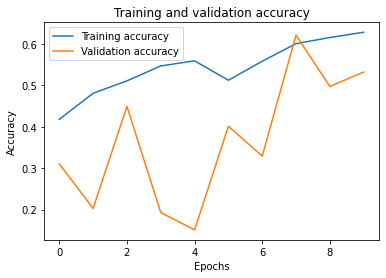

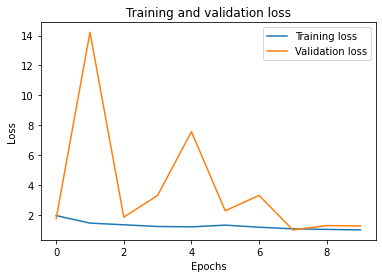

In [23]:
displayAccuracy(result_resnet_model)
displayLoss(result_resnet_model)

Le temps investis semblent cependant bénéfique, la précision aussi bien en validation qu'en training étant bien plus importante que les modèles que nous avions jusqu'à présent.

Nous pouvons ensuite sauvegarder et utiliser le modèle pour analyser nos images:

In [24]:
resnet_model.save('resnet50.h5')
resnet_model.save_weights('resnet50-weights.h5')
print('ResNet50 Prediction :', (resnet_model.predict(pre_x)))

ResNet50 Prediction : [[0.01701816 0.4690376  0.03311397 0.1657682  0.20104003 0.11402199]
 [0.01688724 0.46327716 0.0332136  0.17132097 0.20402649 0.11127453]
 [0.01681144 0.46037146 0.03325706 0.17421705 0.20550737 0.1098356 ]
 [0.01684737 0.4618536  0.03325827 0.17257875 0.20482668 0.11063527]
 [0.01687481 0.46214166 0.03327462 0.17207697 0.20469888 0.11093305]
 [0.01680782 0.46239024 0.03324232 0.17233412 0.20434335 0.11088209]]
